In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.applications import EfficientNetB0
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
batch_size = 32
dataset_code = 'A'
model_name = 'EfficientNetB0'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
model_saved_dir = r'D:\My Code\Classification\models'
train_data_path = f'{data_saved_dir}\A_training.pkl'
val_data_path = f'{data_saved_dir}\A_validation.pkl'
test_data_path = f'{data_saved_dir}\A_testing.pkl'

In [3]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (3921, 256, 256, 3)
Validation images: (838, 256, 256, 3)
Testing images: (845, 256, 256, 3)


In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [5]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 4,217,932
Trainable params: 4,175,909
Non-trainable params: 42,023
_________________________________________________________________


c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
filepath = f'{model_dir}\{dataset_code}_{model_name}-{filename}.hdf5'
 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stop]

D:\My Code\Classification\models\A_EfficientNetB0 already exists


In [7]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8972
Epoch 1: val_accuracy improved from -inf to 0.84726, saving model to D:\My Code\Classification\models\A_EfficientNetB0\A_EfficientNetB0-weights-improvement-01-0.85.hdf5
123/123 [==============================] - 48s 297ms/step - loss: 0.2846 - accuracy: 0.8972 - val_loss: 0.7192 - val_accuracy: 0.8473
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9806
Epoch 2: val_accuracy improved from 0.84726 to 0.84845, saving model to D:\My Code\Classification\models\A_EfficientNetB0\A_EfficientNetB0-weights-improvement-02-0.85.hdf5
123/123 [==============================] - 34s 274ms/step - loss: 0.0610 - accuracy: 0.9806 - val_loss: 0.7440 - val_accuracy: 0.8484
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9895
Epoch 3: val_accuracy did not improve from 0.84845
123/123 [==============================] - 33s 269ms

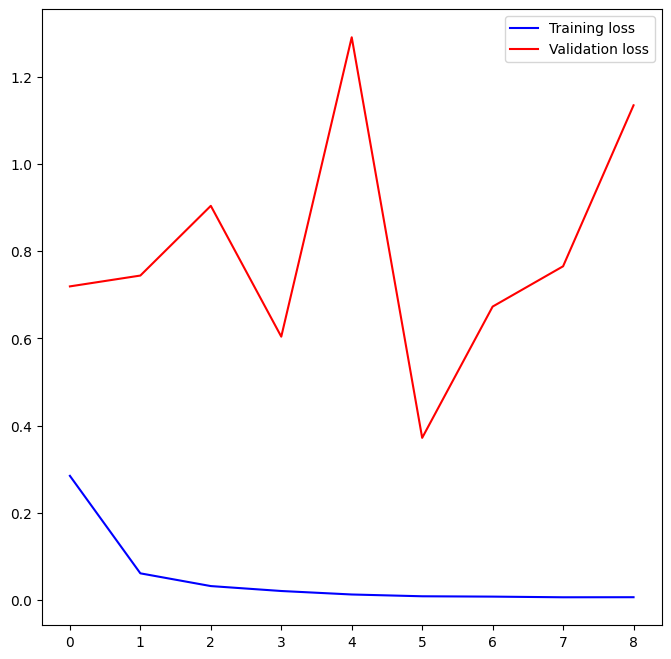

<Figure size 640x480 with 0 Axes>

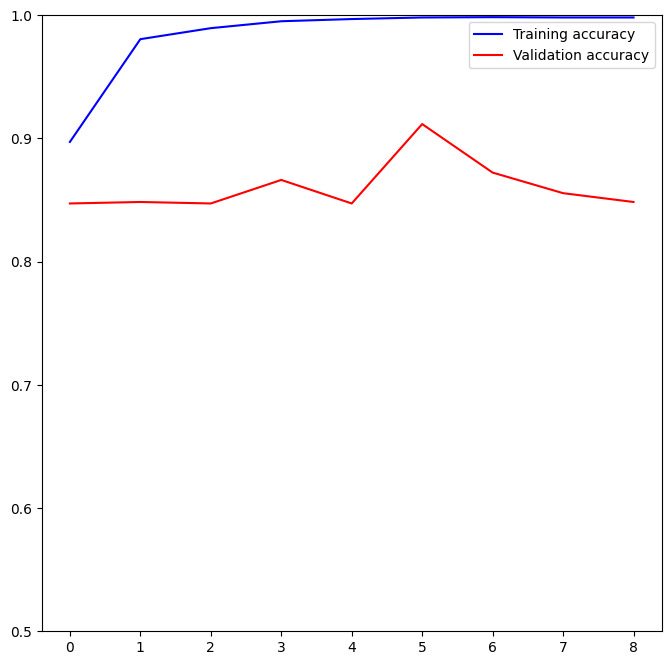

In [8]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

27/27 [==============================] - 3s 69ms/step


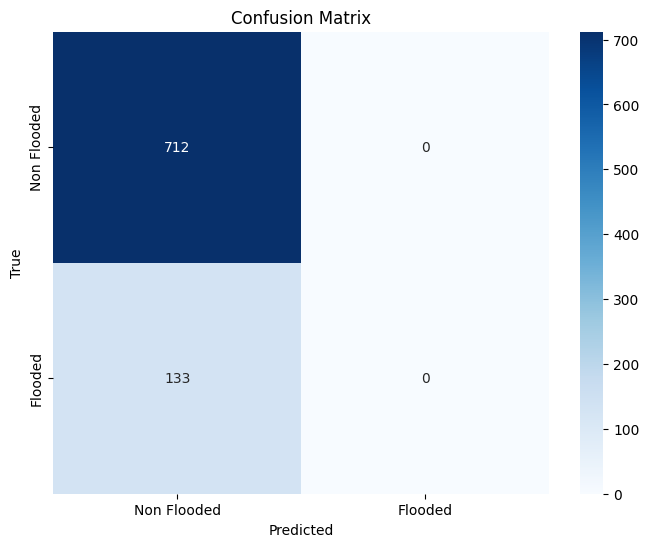

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       712
           1       0.00      0.00      0.00       133

    accuracy                           0.84       845
   macro avg       0.42      0.50      0.46       845
weighted avg       0.71      0.84      0.77       845



c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [9]:
predictions = model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

#### Testing on model which is last best saved

['A_EfficientNetB0-weights-improvement-06-0.91.hdf5']
Best model loaded ...
27/27 [==============================] - 3s 55ms/step


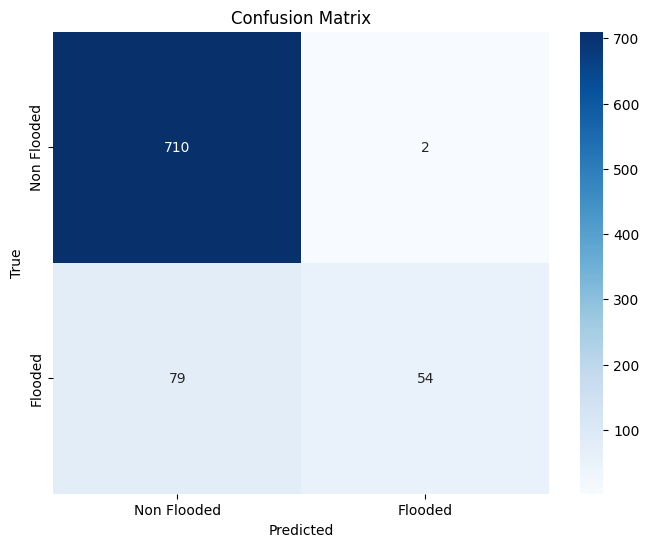

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       712
           1       0.96      0.41      0.57       133

    accuracy                           0.90       845
   macro avg       0.93      0.70      0.76       845
weighted avg       0.91      0.90      0.89       845



In [10]:
models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))